## Intro.

In this notebook, we build a GAN to generate images similar to the MNIST dataset by following the work of Goodfellow et al., "Generative Adversarial Nets", NeurIPS'14. As always, we start by loading dependencies.

In [1]:
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

The generator here is a 4-layer MLP. Note that we use Leaky ReLU instead of ReLU as training GANs usually requires a lot of patience. 

In [2]:
class GAN_G_Model(nn.Module):
    def __init__(self, z_dim = 100):
        super(GAN_G_Model, self).__init__()       
        self.fc1 = nn.Linear(z_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    # forward method
    def forward(self, x): 
        x = self.leaky_relu(self.fc1(x))
        x = self.leaky_relu(self.fc2(x))
        x = self.leaky_relu(self.fc3(x))
        return torch.tanh(self.fc4(x))

The discriminator is again a 4-layer MLP which accepts an image (fake/real) and predicts a score in the range [0,1]. Here, 1 means real, 0 means fake.

In [3]:
class GAN_D_Model(nn.Module):
    def __init__(self):
        super(GAN_D_Model, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.2)
    # forward method
    def forward(self, x):
        x = self.leaky_relu(self.fc1(x))
        x = F.dropout(x, 0.3)
        x = self.leaky_relu(self.fc2(x))
        x = F.dropout(x, 0.3)
        x = self.leaky_relu(self.fc3(x))
        x = F.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))

## Training

This is the most important part of the code. To train a GAN, you perform the following three steps,

1- feed the discrimnator with real images and get the gradient.
2- feed the discrimnator with fake images and get the gradient.

3- Use the gradient from 1 and 2 to update the discriminator.

4- Feed the genrator with random vectors and get its output.
5- Use 4 and the discriminator to compute the gradient of the generator.
6- Update the generator

In [4]:
def train_GAN(x): 
    #first we update the discriminator
    num_imgs = x.shape[0]
    x_real = x.view(-1, 784).to(device)
      
    GAN_D.zero_grad()
    # train discriminator on real images
    #============================
    y_real = torch.ones(num_imgs, 1).to(device)
    D_output_real = GAN_D(x_real)
    #recall BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
    D_loss_real = criterion(D_output_real, y_real)


    # train discriminator on fake images
    #============================
    z = torch.randn(num_imgs, z_dim).to(device)
    x_fake = GAN_G(z)    
    y_fake = torch.zeros(num_imgs, 1).to(device)

    D_output_fake = GAN_D(x_fake)
    D_loss_fake = criterion(D_output_fake, y_fake)


    # optimize the discriminator's parameters
    D_loss_total = (D_loss_real + D_loss_fake)/2
    D_loss_total.backward()
    D_optimizer.step()
        
        
#=======================Train the generator=======================#
    GAN_G.zero_grad()

    z = torch.randn(num_imgs, z_dim).to(device)
    G_output = GAN_G(z)
    # train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
    # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
    D_output = GAN_D(G_output)
    G_loss = criterion(D_output, y_real)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return D_loss_total.data.item(), G_loss.data.item()

Loading data and instantiating the networks

In [5]:
cuda = torch.cuda.is_available()
n_workers = multiprocessing.cpu_count()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 32 #use a small batch size    


MNIST_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])])
    
    
train_data = torchvision.datasets.MNIST(root = '../../data', 
                                        download=False,
                                        transform=MNIST_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                          shuffle=False, num_workers=n_workers)
    
GAN_G = GAN_G_Model().to(device)
GAN_D = GAN_D_Model().to(device)



The dimenionality of the random vector is 100. Below, we set up the optimizers (the learning rate is 0.0002 for ADAM optimizers for this experiment)

In [6]:
z_dim = 100
criterion = nn.BCELoss().to(device)
learning_rate = 0.0002 
G_optimizer = optim.Adam(GAN_G.parameters(), lr=learning_rate)
D_optimizer = optim.Adam(GAN_D.parameters(), lr=learning_rate)



### Training Loop

We train the model for 300 epochs. 

In [7]:
num_epoch = 300
D_loss, G_loss = [], []
for epoch in range(1, num_epoch+1):           

    D_losses_iter, G_losses_iter = [], []
    for batch_idx, (x, _) in enumerate(train_loader):
        tmp_loss_D, tmp_loss_G = train_GAN(x)
        D_losses_iter.append(tmp_loss_D)
        G_losses_iter.append(tmp_loss_G)

    total_Loss_D = torch.mean(torch.FloatTensor(D_losses_iter))
    D_loss.append(total_Loss_D)
    total_Loss_G = torch.mean(torch.FloatTensor(G_losses_iter))
    G_loss.append(total_Loss_G)
    print('[{0:2d}/{1:2d}]: loss_d: {2:.3f}, loss_g: {3:.3f}'.format(
            epoch, num_epoch, total_Loss_D, total_Loss_G))

[ 1/300]: loss_d: 0.560, loss_g: 1.754
[ 2/300]: loss_d: 0.374, loss_g: 2.077
[ 3/300]: loss_d: 0.386, loss_g: 1.847
[ 4/300]: loss_d: 0.426, loss_g: 1.654
[ 5/300]: loss_d: 0.452, loss_g: 1.585
[ 6/300]: loss_d: 0.473, loss_g: 1.486
[ 7/300]: loss_d: 0.492, loss_g: 1.400
[ 8/300]: loss_d: 0.505, loss_g: 1.342
[ 9/300]: loss_d: 0.543, loss_g: 1.204
[10/300]: loss_d: 0.552, loss_g: 1.163
[11/300]: loss_d: 0.563, loss_g: 1.132
[12/300]: loss_d: 0.576, loss_g: 1.089
[13/300]: loss_d: 0.575, loss_g: 1.090
[14/300]: loss_d: 0.587, loss_g: 1.043
[15/300]: loss_d: 0.595, loss_g: 1.021
[16/300]: loss_d: 0.604, loss_g: 0.996
[17/300]: loss_d: 0.608, loss_g: 0.981
[18/300]: loss_d: 0.608, loss_g: 0.982
[19/300]: loss_d: 0.618, loss_g: 0.941
[20/300]: loss_d: 0.622, loss_g: 0.938
[21/300]: loss_d: 0.625, loss_g: 0.923
[22/300]: loss_d: 0.620, loss_g: 0.942
[23/300]: loss_d: 0.631, loss_g: 0.902
[24/300]: loss_d: 0.638, loss_g: 0.884
[25/300]: loss_d: 0.635, loss_g: 0.894
[26/300]: loss_d: 0.642, 

[209/300]: loss_d: 0.646, loss_g: 0.873
[210/300]: loss_d: 0.647, loss_g: 0.868
[211/300]: loss_d: 0.648, loss_g: 0.865
[212/300]: loss_d: 0.647, loss_g: 0.862
[213/300]: loss_d: 0.646, loss_g: 0.871
[214/300]: loss_d: 0.646, loss_g: 0.870
[215/300]: loss_d: 0.644, loss_g: 0.875
[216/300]: loss_d: 0.646, loss_g: 0.872
[217/300]: loss_d: 0.646, loss_g: 0.873
[218/300]: loss_d: 0.646, loss_g: 0.869
[219/300]: loss_d: 0.646, loss_g: 0.872
[220/300]: loss_d: 0.646, loss_g: 0.869
[221/300]: loss_d: 0.647, loss_g: 0.871
[222/300]: loss_d: 0.645, loss_g: 0.874
[223/300]: loss_d: 0.645, loss_g: 0.872
[224/300]: loss_d: 0.645, loss_g: 0.869
[225/300]: loss_d: 0.646, loss_g: 0.870
[226/300]: loss_d: 0.646, loss_g: 0.870
[227/300]: loss_d: 0.645, loss_g: 0.873
[228/300]: loss_d: 0.646, loss_g: 0.873
[229/300]: loss_d: 0.647, loss_g: 0.871
[230/300]: loss_d: 0.645, loss_g: 0.875
[231/300]: loss_d: 0.646, loss_g: 0.872
[232/300]: loss_d: 0.644, loss_g: 0.874
[233/300]: loss_d: 0.646, loss_g: 0.875


## Generating images

Now that the model is trained, we can easily generate new samples. Check out the cell below.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


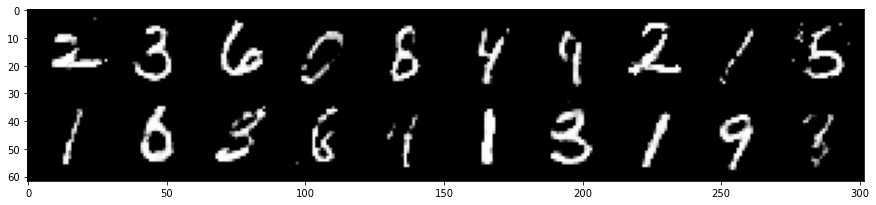

In [8]:
with torch.no_grad():
    test_z = torch.randn(20, z_dim).to(device)
    gen_imgs = GAN_G(test_z)
    gen_imgs = gen_imgs.view(-1,1,28,28).to('cpu')

    grid = torchvision.utils.make_grid(gen_imgs, nrow = 10)
    plt.figure(figsize= (15,15))
    plt.imshow(np.transpose(grid, (1,2,0)))